# DESAFIO QI3
- Análise dos dados Big Store
- Criação de Gráficos aqui e no Tableau
- Importação e Exportação de arquivo Excel

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans

### Conhecendo os Dados

In [2]:
# Puxando o dataset e criando o dataframe
dataset = pd.read_excel('BIGSTORE_ANTES.xlsx')

In [3]:
dataset.head()

,ID_Pedido,ID_Loja,ID_Cliente,Data_Compra,Quantidade_Itens,Quantidade_Envios,Lucro,Vendas,ID_Cidade,Nome_Loja,...,Cidade,ID_Pais,Estado,Pais,Nome_Cliente,ID_Item,ID_Produto,Produto,Unnamed: 19,Unnamed: 20
0,1,1,1,2015-01-03,1,1,448.8000,1952.0000,410,Mixco,...,Mixco,11,Guatemala,Guatemala,Tânia Rodrigues,1309.0,54.0,Headset,NaN,NaN
1,2,3,5,2015-01-04,2,2,6380.0000,17974.0000,146,Francisco Beltrão,...,Francisco Beltrão,4,Paraná,Brasil,Rebeca Fernandes,779.0,1.0,Abridor de carta,NaN,NaN
2,2,3,5,2015-01-04,2,2,6380.0000,17974.0000,146,Francisco Beltrão,...,Francisco Beltrão,4,Paraná,Brasil,Rebeca Fernandes,563.0,38.0,Estante tradicional,NaN,NaN
3,3,6,4,2015-01-04,2,2,627.0824,3881.0824,545,Mérida,...,Mérida,16,Yucatán,México,Luís Sousa,738.0,94.0,Teclado,NaN,NaN
4,3,6,4,2015-01-04,2,2,627.0824,3881.0824,545,Mérida,...,Mérida,16,Yucatán,México,Luís Sousa,1684.0,100.0,Tinta,NaN,NaN


In [4]:
# 20161 entradas
# 21 colunas, duas nulas
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20161 entries, 0 to 20160
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID_Pedido          20161 non-null  int64         
 1   ID_Loja            20161 non-null  int64         
 2   ID_Cliente         20161 non-null  int64         
 3   Data_Compra        20159 non-null  datetime64[ns]
 4   Quantidade_Itens   20161 non-null  int64         
 5   Quantidade_Envios  20161 non-null  int64         
 6   Lucro              20160 non-null  float64       
 7   Vendas             20160 non-null  float64       
 8   ID_Cidade          20161 non-null  int64         
 9   Nome_Loja          20161 non-null  object        
 10  ID_Estado          20161 non-null  int64         
 11  Cidade             20161 non-null  object        
 12  ID_Pais            20161 non-null  int64         
 13  Estado             20161 non-null  object        
 14  Pais  

In [5]:
# Colunas sem utilidade
dataset = dataset.drop(columns=['Unnamed: 19','Unnamed: 20'])


# Colunas que contém "IDs"não são utilizavéis, pois, foram transformados para seu verdadeiro valor. Irei manter somente 
# o "ID_Loja" e "ID_Pedido"
dataset = dataset.drop(columns=['ID_Item', 'ID_Produto', 'ID_Pais', 'ID_Estado', 'ID_Cidade'])


# Nome das lojas é igual ao nome das cidades, então é desnecessário manter as duas no dataset. Além de que, provavelmente,
# ocorreu um erro de preenchimento da coluna 'Nome_Loja'
(dataset['Nome_Loja'] == dataset['Cidade']).value_counts() # Todos verdadeiros, ou seja, iguais.
dataset = dataset.drop(columns='Nome_Loja')


dataset.shape

(20161, 13)

In [6]:
# Verificando se tem pedido repetido
# Separei em um outro dataset
dataset[['ID_Pedido']].duplicated().value_counts(); 

dataset_pedido = dataset.drop_duplicates(subset='ID_Pedido')

dataset_pedido.shape

(5145, 13)

## Ajustando a Variável 'Data_Compra'

In [7]:
# Duas informações com falta de Data.
dataset_pedido[dataset_pedido['Data_Compra'].isna()]

,ID_Pedido,ID_Loja,ID_Cliente,Data_Compra,Quantidade_Itens,Quantidade_Envios,Lucro,Vendas,Cidade,Estado,Pais,Nome_Cliente,Produto
68,39,35,36,NaT,1,1,NaN,NaN,Bayamo,Granma,Cuba,Sofia Melo,Repetidor de sinal
93,49,32,46,NaT,1,1,-1217.92,1074.48,Santo Domingo,Santo Domingo,República Dominicana,Gabriela Martins,Impressora


In [8]:
# É notável que uma delas não tem "Lucro" e nem "Vendas", então, foi retirada, pois,
# não contém informações importante nela. Mas seria interessante pesquisar o porquê de estar vazia.
dataset_pedido = dataset_pedido.drop(68).reset_index(drop=True)
dataset_pedido.shape

(5144, 13)

In [9]:
# Assumindo que as ordens dos pedidos estão em ordem crescente, podemos colocar a mesma data do pedido anterior e do posterior
dataset_pedido.iloc[[46,47,48]]

,ID_Pedido,ID_Loja,ID_Cliente,Data_Compra,Quantidade_Itens,Quantidade_Envios,Lucro,Vendas,Cidade,Estado,Pais,Nome_Cliente,Produto
46,48,41,45,2015-02-24,3,3,3245.1504,11818.1504,Pelotas,Rio Grande do Sul,Brasil,Caio Souza,Fax sem fio
47,49,32,46,NaT,1,1,-1217.9200,1074.4800,Santo Domingo,Santo Domingo,República Dominicana,Gabriela Martins,Impressora
48,50,40,46,2015-02-24,1,1,-859.7600,1432.6400,Bom Jesus da Lapa,Bahia,Brasil,Gabriela Martins,Impressora


In [10]:
# Data_Compra ajustado
dataset_pedido['Data_Compra'].iloc[47] = np.datetime64('2015-02-24')
dataset_pedido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID_Pedido          5144 non-null   int64         
 1   ID_Loja            5144 non-null   int64         
 2   ID_Cliente         5144 non-null   int64         
 3   Data_Compra        5144 non-null   datetime64[ns]
 4   Quantidade_Itens   5144 non-null   int64         
 5   Quantidade_Envios  5144 non-null   int64         
 6   Lucro              5144 non-null   float64       
 7   Vendas             5144 non-null   float64       
 8   Cidade             5144 non-null   object        
 9   Estado             5144 non-null   object        
 10  Pais               5144 non-null   object        
 11  Nome_Cliente       5144 non-null   object        
 12  Produto            5133 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(5)
memory us

## Ajustando Variável Produto

In [11]:
# "Produto" possue 11 informações incompletas
dataset_pedido[dataset_pedido['Produto'].isna()]

,ID_Pedido,ID_Loja,ID_Cliente,Data_Compra,Quantidade_Itens,Quantidade_Envios,Lucro,Vendas,Cidade,Estado,Pais,Nome_Cliente,Produto
265,267,40,45,2015-06-17,1,1,-5352.9600,3691.4400,Bom Jesus da Lapa,Bahia,Brasil,Caio Souza,NaN
915,917,299,536,2016-01-29,7,7,1292.2584,14246.8584,Portmore,Saint Catherine,Jamaica,Brenda Barros,NaN
1154,1156,91,76,2016-05-23,1,1,-310.8000,207.2000,Araranguá,Santa Catarina,Brasil,Nicole Ribeiro,NaN
2059,2061,57,183,2017-02-15,2,2,-1987.9632,4743.2368,Caracas,Distrito Capital,Venezuela,Vinicius Fernandes,NaN
2815,2817,348,722,2017-09-15,2,2,-462.5600,547.8400,Belo Horizonte,Minas Gerais,Brasil,Diego Silva,NaN
3499,3501,141,395,2018-01-23,1,1,-117.7200,146.8800,Presidente Dutra,Maranhão,Brasil,Carolina Goncalves,NaN
3526,3528,144,773,2018-02-11,1,1,-22.8000,272.4000,Colón,Colón,Panamá,Enzo Ferreira,NaN
3593,3595,56,164,2018-03-11,3,3,3285.4000,12119.8000,Consolación del Sur,Pinar del Rio,Cuba,Sofia Araujo,NaN
4136,4138,141,76,2018-07-21,5,5,-6094.8548,8317.3452,Presidente Dutra,Maranhão,Brasil,Nicole Ribeiro,NaN
4365,4367,367,68,2018-09-12,1,1,-5453.5200,4641.2800,Açu,Rio Grande do Norte,Brasil,Vitór Dias,NaN


In [12]:
# Preenchi os NaN pela palavra Outros, além de diferenciar dos outros produtos, poderemos utilizar as informações por completo
# ao utilizar a base de dados
dataset_pedido['Produto'] = dataset_pedido['Produto'].fillna('Outros')

In [13]:
dataset_pedido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID_Pedido          5144 non-null   int64         
 1   ID_Loja            5144 non-null   int64         
 2   ID_Cliente         5144 non-null   int64         
 3   Data_Compra        5144 non-null   datetime64[ns]
 4   Quantidade_Itens   5144 non-null   int64         
 5   Quantidade_Envios  5144 non-null   int64         
 6   Lucro              5144 non-null   float64       
 7   Vendas             5144 non-null   float64       
 8   Cidade             5144 non-null   object        
 9   Estado             5144 non-null   object        
 10  Pais               5144 non-null   object        
 11  Nome_Cliente       5144 non-null   object        
 12  Produto            5144 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(5)
memory us

In [14]:
dataset_final = dataset_pedido.to_excel('BIGSTORE_LIMPO.xlsx', index=False)

## Informações Interessantes no Dataset

In [15]:
# 10 dias no qual teve bastante compras, porquê?
dataset['Data_Compra'].value_counts().head(15)

2018-09-26    924
2018-09-12    915
2018-07-21    914
2018-03-11    909
2018-02-11    904
2015-06-17    901
2018-01-23    901
2017-02-15    900
2016-05-23    900
2017-09-15    900
2016-01-29    898
2018-11-20     39
2017-09-21     37
2018-11-10     37
2017-12-21     36
Name: Data_Compra, dtype: int64

In [16]:
# Repetição de ID do Cliente na planilha
dataset_pedido['ID_Cliente'].value_counts()

134    15
68     15
261    14
230    14
24     14
       ..
634     1
614     1
370     1
62      1
766     1
Name: ID_Cliente, Length: 794, dtype: int64

In [17]:
# Repetição de Nome Cliente na Planilha
dataset_pedido['Nome_Cliente'].value_counts()

Giovanna Oliveira    33
Pedro Dias           30
Sophia Pereira       28
Livia Santos         25
Vinicius Silva       22
                     ..
Arthur Azevedo        1
Ana Rodrigues         1
Enzo Barbosa          1
Estevan Santos        1
Kauã Rocha            1
Name: Nome_Cliente, Length: 719, dtype: int64

Era para apresentar valores iguais,porém tem cliente que possui mais do que um ID

## Parte 3: Algoritmo de Machine Learning

Com objetivo de separar os clientes em grupos, irei usar o método de clusterização, através do algoritmo KMeans. Separando os clientes em 3 grupos (Ouro, Prata, Bronze).

In [18]:
df_kmeans = dataset_pedido[['ID_Cliente','Nome_Cliente','Vendas']].groupby('ID_Cliente')['Vendas'].sum()

In [19]:
df_kmeans2 = pd.DataFrame(df_kmeans).reset_index()

In [20]:
df_kmeans2.head()

,ID_Cliente,Vendas
0,1,14083.2000
1,2,16730.9756
2,3,24423.3400
3,4,20161.5944
4,5,78031.5232


In [21]:
# Algoritmo 
kmeans = KMeans(n_clusters = 3, random_state = 0)

In [22]:
# Treinamento
kmeans.fit(df_kmeans2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

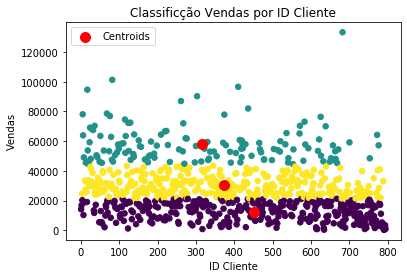

In [36]:
# Montagem do Gráfico gerado
plt.scatter(df_kmeans2.loc[:, 'ID_Cliente'], df_kmeans2.loc[:, 'Vendas'], s = 30, c = kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'red',label = 'Centroids')
plt.title('Classificção Vendas por ID Cliente')
plt.xlabel('ID Cliente')
plt.ylabel('Vendas')
plt.legend()

plt.show()

In [24]:
# Criando nova coluna
df_kmeans2['Classificacao'] = kmeans.labels_

df_kmeans2.head()

,ID_Cliente,Vendas,Classificacao
0,1,14083.2000,0
1,2,16730.9756,0
2,3,24423.3400,2
3,4,20161.5944,0
4,5,78031.5232,1


In [25]:
# Função do rank 
def Medalha(arrow):
    if arrow == 0:
        return 'Bronze'
    elif arrow == 1:
        return 'Ouro'
    else:
        return 'Prata'

In [26]:
# Criando coluna de rank para os clientes
df_kmeans2['Medalha'] = df_kmeans2['Classificacao'].map(Medalha)

df_kmeans2.head()

,ID_Cliente,Vendas,Classificacao,Medalha
0,1,14083.2000,0,Bronze
1,2,16730.9756,0,Bronze
2,3,24423.3400,2,Prata
3,4,20161.5944,0,Bronze
4,5,78031.5232,1,Ouro


In [27]:
# Mandando formato excel para ser explorado no Tableau
df_final = df_kmeans2.drop(columns='Classificacao').to_excel('Podio_Cliente.xlsx', index=False)